# Import Libs

In [1]:
import json
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from datasets import load_dataset
from matplotlib.patches import Patch
from scipy import stats


/Users/oguzgultepe/anaconda3/envs/thesis/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Results

In [3]:
all_results = []
for fname in os.listdir():
    if 'test' in fname and '.ipynb' not in fname:
        with open(fname, 'r') as f:
            results = json.load(f)
        model_name = results['MODEL_CONFIG']['MODEL_PATH']
        for test in results['TESTS']:
            test_result = test['CONFIG'].copy()
            test_result['MODEL'] = model_name
            test_result['EM'] = test['EM']
            test_result['RESULTS'] = test['RESULTS']
            all_results.append(test_result)
all_results = pd.DataFrame(all_results)


In [4]:
all_results


,DATASET_NAME,SAMPLING,ADJUST_SCORES,PROMPT_SIZE,MODEL,EM,RESULTS
0,trivia_qa,pool-prob,True,5,stabilityai/StableBeluga-13B,0.537,"[{'q_id': 0, 'em': False, 'instructions': [{'i..."
1,trivia_qa,pool-prob,True,8,stabilityai/StableBeluga-13B,0.531,"[{'q_id': 0, 'em': False, 'instructions': [{'i..."
2,trivia_qa,pool-prob,True,12,stabilityai/StableBeluga-13B,0.544,"[{'q_id': 0, 'em': False, 'instructions': [{'i..."
3,trivia_qa,direct,False,3,stabilityai/StableBeluga-13B,0.552,"[{'q_id': 0, 'em': False, 'instructions': None..."
4,trivia_qa,random,False,3,stabilityai/StableBeluga-13B,0.537,"[{'q_id': 0, 'em': False, 'instructions': [{'i..."
5,trivia_qa,pool-random,False,3,stabilityai/StableBeluga-13B,0.537,"[{'q_id': 0, 'em': False, 'instructions': [{'i..."
6,hotpot_qa,direct,False,3,stabilityai/StableBeluga-13B,0.212,"[{'q_id': 0, 'em': False, 'instructions': None..."
7,hotpot_qa,random,False,3,stabilityai/StableBeluga-13B,0.244,"[{'q_id': 0, 'em': True, 'instructions': [{'id..."
8,hotpot_qa,pool-random,False,3,stabilityai/StableBeluga-13B,0.250,"[{'q_id': 0, 'em': True, 'instructions': [{'id..."
9,hotpot_qa,pool-prob,True,3,stabilityai/StableBeluga-13B,0.245,"[{'q_id': 0, 'em': True, 'instructions': [{'id..."


# Summarize

In [5]:
prompt_size_filter = all_results.PROMPT_SIZE == 3
sampling_filter = (
    (
        all_results.SAMPLING.isin(
            ['direct', 'random', 'pool-random']
        )
    )
    | (
        (all_results.SAMPLING == 'pool-prob')
        & (all_results.ADJUST_SCORES == True)
    )
)
summary_filter = (prompt_size_filter) & (sampling_filter)


In [6]:
def sampling_map(sampling):
    match sampling:
        case 'direct':
            return 'Direct Prompting'
        case 'random':
            return 'Random Sampling'
        case 'pool-random':
            return 'Similarity Pooling + Random Sampling'
        case 'pool-prob':
            return 'Similarity Pooling + Probabilistic Sampling'
        

In [7]:
summary = all_results.copy()
summary = summary[summary_filter]
summary.SAMPLING = summary.SAMPLING.map(sampling_map)
summary.MODEL = summary.MODEL.map(
    lambda m: '13B' if '13B' in m else '70B'
)
summary.DATASET_NAME = summary.DATASET_NAME.map(
    lambda d: 'HotpotQA' if d == 'hotpot_qa' else 'TriviaQA'
)
summary.index = pd.MultiIndex.from_arrays([summary.DATASET_NAME, summary.MODEL])
summary = summary[['SAMPLING', 'EM']]
summary = summary.pivot(columns = ['SAMPLING'])
summary = summary.loc[['TriviaQA', 'HotpotQA']]


In [8]:
summary

EM                  \
SAMPLING           Direct Prompting Random Sampling   
DATASET_NAME MODEL                                    
TriviaQA     13B              0.552           0.537   
             70B              0.616           0.630   
HotpotQA     13B              0.212           0.244   
             70B              0.261           0.272   

                                                                \
SAMPLING           Similarity Pooling + Probabilistic Sampling   
DATASET_NAME MODEL                                               
TriviaQA     13B                                         0.559   
             70B                                         0.629   
HotpotQA     13B                                         0.245   
             70B                                         0.264   

                                                         
SAMPLING           Similarity Pooling + Random Sampling  
DATASET_NAME MODEL                                       
TriviaQA     13B                                  0.537  
             70B                                  0.625  
HotpotQA     13B                                  0.250  
             70B                                  0.278

# Analyze

## Select scores

In [180]:
selected_results = all_results[
    (all_results.DATASET_NAME == 'trivia_qa')
    & (all_results.SAMPLING == 'pool-prob')
    & (all_results.ADJUST_SCORES == True )
    & (all_results.MODEL == 'stabilityai/StableBeluga-13B')
    & (all_results.PROMPT_SIZE == 3)
].iloc[0].RESULTS
ems = [r['em'] for r in selected_results]
scores = [
    [i['score'] for i in  r['instructions']]
    for r in selected_results
]


## Plot Scores and calculate metrics

### All Scores

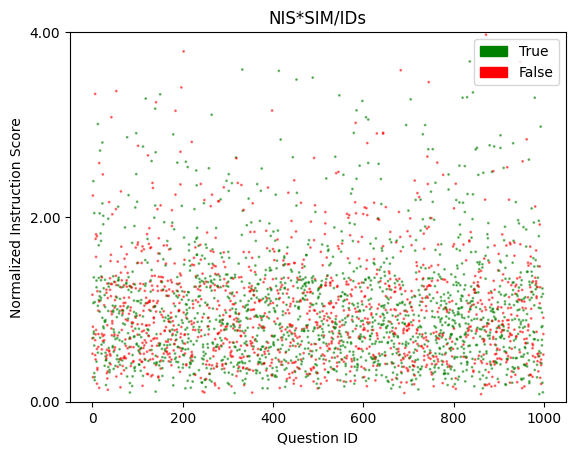


(NIS*SIM) ~ EM
p-value ≈ 0.33034

Acc:	55.9%
TP:	55.9%
FP:	44.1%
TN:	0.0%
FN:	0.0%


In [181]:
# Draw scatterplot
all_scores = sum(scores, [])
color = sum(map(lambda em:['green'] * 3 if em else ['red'] * 3, ems), [])
test_size = len(ems)
ids = sum([[i] * 3 for i in range(test_size)], [])
plt.scatter(ids, all_scores, color=color, s=1, alpha=0.5)
# Calculate and draw threshold
lr = stats.linregress(all_scores, sum(map(lambda em: [em] * 3, ems), []), alternative='greater')
threshold = round((0.5 - lr.intercept) / lr.slope, 2)
plt.plot(ids, [threshold] * test_size * 3, color='black')
# Add tick for the threshold
locs, _ = plt.yticks()
plt.yticks(locs.tolist() + [threshold])
# Add title and labels
plt.title(f'NIS*SIM/IDs')
plt.xlabel('Question ID')
plt.ylabel(f'Normalized Instruction Score')
# Set plot limits
ylim_upper = np.ceil(np.quantile(all_scores, 0.99))
plt.ylim(0, ylim_upper)
# Draw legend
green_patch = Patch(color='green', label='True')
red_patch = Patch(color='red', label='False')
handles = [green_patch, red_patch]
plt.legend(handles=handles, loc='upper right')
# Show plot
plt.show()

# Calculate metrics
fp, fn, tp, tn = 0, 0, 0, 0
for score, em in zip(all_scores, sum(map(lambda em: [em] * 3, ems), [])):
    if score >= threshold and not em:
        fp += 1
    elif score < threshold and em:
        fn += 1
    elif score >= threshold and em:
        tp += 1
    elif score < threshold and not em:
        tn += 1
fp /= test_size * 3
fn /= test_size * 3
tp /= test_size * 3
tn /= test_size * 3
acc = tp + tn
# Print metrics
print(f"\n(NIS*SIM) ~ EM")
print(f"p-value ≈ {round(lr.pvalue, 5)}\n")
print(f"Acc:\t{round(acc * 100, 1)}%")
print(f"TP:\t{round(tp * 100, 1)}%")
print(f"FP:\t{round(fp * 100, 1)}%")
print(f"TN:\t{round(tn * 100, 1)}%")
print(f"FN:\t{round(fn * 100, 1)}%")


### Min Scores

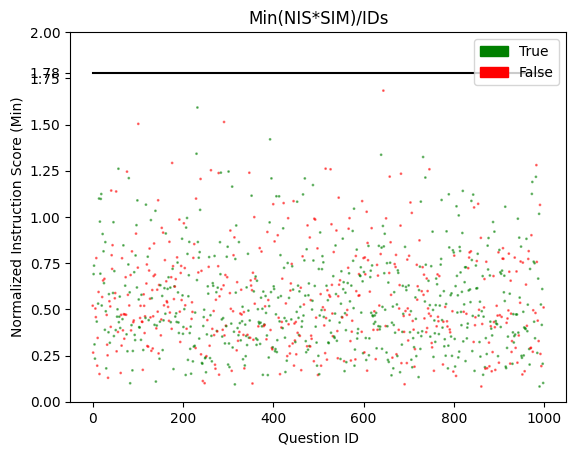


Min(NIS*SIM) ~ EM
p-value ≈ 0.79479

Acc:	44.1%
TP:	0.0%
FP:	0.0%
TN:	44.1%
FN:	55.9%


In [182]:
# Apply function
func = min
func_scores = list(map(func, scores))
# Draw scatterplot
color = list(map(lambda em:'green' if em else 'red', ems))
test_size = len(ems)
ids = list(range(test_size))
plt.scatter(ids, func_scores, color=color, s=1, alpha=0.5)
# Calculate and draw threshold
lr = stats.linregress(func_scores, ems, alternative='greater')
threshold = round((0.5 - lr.intercept) / lr.slope, 2)
plt.plot(ids, [threshold] * test_size, color='black')
# Add tick for the threshold
locs, _ = plt.yticks()
plt.yticks(locs.tolist() + [threshold])
# Add title and labels
func_name = func.__name__.capitalize() 
plt.title(f'{func_name}(NIS*SIM)/IDs')
plt.xlabel('Question ID')
plt.ylabel(f'Normalized Instruction Score ({func_name})')
# Set plot limits
ylim_upper = np.ceil(np.quantile(func_scores, 0.99))
plt.ylim(0, ylim_upper)
# Draw legend
green_patch = Patch(color='green', label='True')
red_patch = Patch(color='red', label='False')
handles = [green_patch, red_patch]
plt.legend(handles=handles, loc='upper right')
# Show plot
plt.show()

# Calculate metrics
fp, fn, tp, tn = 0, 0, 0, 0
for score, em in zip(func_scores, ems):
    if score >= threshold and not em:
        fp += 1
    elif score < threshold and em:
        fn += 1
    elif score >= threshold and em:
        tp += 1
    elif score < threshold and not em:
        tn += 1
fp /= test_size
fn /= test_size
tp /= test_size
tn /= test_size
acc = tp + tn
# Print metrics
print(f"\n{func_name}(NIS*SIM) ~ EM")
print(f"p-value ≈ {round(lr.pvalue, 5)}\n")
print(f"Acc:\t{round(acc * 100, 1)}%")
print(f"TP:\t{round(tp * 100, 1)}%")
print(f"FP:\t{round(fp * 100, 1)}%")
print(f"TN:\t{round(tn * 100, 1)}%")
print(f"FN:\t{round(fn * 100, 1)}%")


### Max Scores

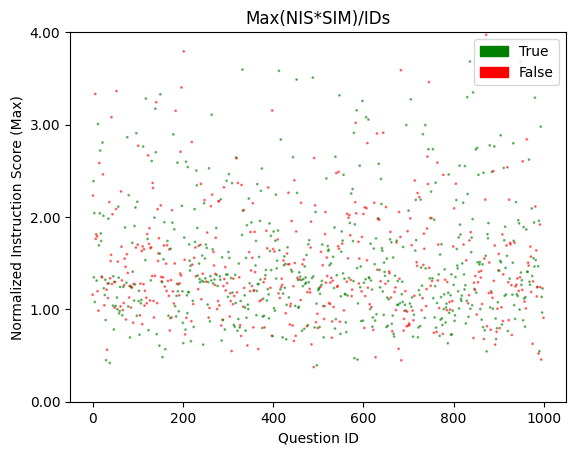


Max(NIS*SIM) ~ EM
p-value ≈ 0.20891

Acc:	55.9%
TP:	55.9%
FP:	44.1%
TN:	0.0%
FN:	0.0%


In [183]:
# Apply function
func = max
func_scores = list(map(func, scores))
# Draw scatterplot
color = list(map(lambda em:'green' if em else 'red', ems))
test_size = len(ems)
ids = list(range(test_size))
plt.scatter(ids, func_scores, color=color, s=1, alpha=0.5)
# Calculate and draw threshold
lr = stats.linregress(func_scores, ems, alternative='greater')
threshold = round((0.5 - lr.intercept) / lr.slope, 2)
plt.plot(ids, [threshold] * test_size, color='black')
# Add tick for the threshold
locs, _ = plt.yticks()
plt.yticks(locs.tolist() + [threshold])
# Add title and labels
func_name = func.__name__.capitalize() 
plt.title(f'{func_name}(NIS*SIM)/IDs')
plt.xlabel('Question ID')
plt.ylabel(f'Normalized Instruction Score ({func_name})')
# Set plot limits
ylim_upper = np.ceil(np.quantile(func_scores, 0.99))
plt.ylim(0, ylim_upper)
# Draw legend
green_patch = Patch(color='green', label='True')
red_patch = Patch(color='red', label='False')
handles = [green_patch, red_patch]
plt.legend(handles=handles, loc='upper right')
# Show plot
plt.show()

# Calculate metrics
fp, fn, tp, tn = 0, 0, 0, 0
for score, em in zip(func_scores, ems):
    if score >= threshold and not em:
        fp += 1
    elif score < threshold and em:
        fn += 1
    elif score >= threshold and em:
        tp += 1
    elif score < threshold and not em:
        tn += 1
fp /= test_size
fn /= test_size
tp /= test_size
tn /= test_size
acc = tp + tn
# Print metrics
print(f"\n{func_name}(NIS*SIM) ~ EM")
print(f"p-value ≈ {round(lr.pvalue, 5)}\n")
print(f"Acc:\t{round(acc * 100, 1)}%")
print(f"TP:\t{round(tp * 100, 1)}%")
print(f"FP:\t{round(fp * 100, 1)}%")
print(f"TN:\t{round(tn * 100, 1)}%")
print(f"FN:\t{round(fn * 100, 1)}%")


### Sum Scores

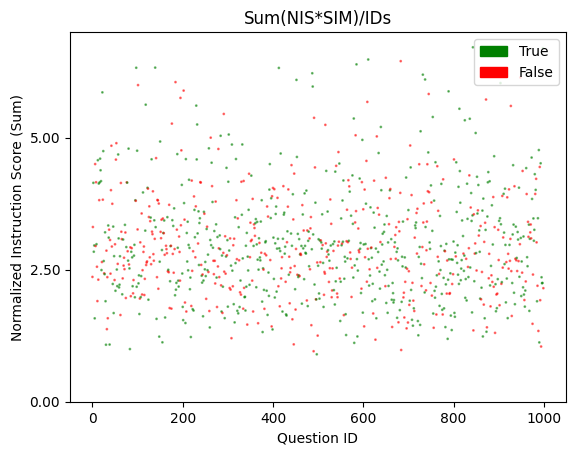


Sum(NIS*SIM) ~ EM
p-value ≈ 0.33225

Acc:	55.9%
TP:	55.9%
FP:	44.1%
TN:	0.0%
FN:	0.0%


In [184]:
# Apply function
func = sum
func_scores = list(map(func, scores))
# Draw scatterplot
color = list(map(lambda em:'green' if em else 'red', ems))
test_size = len(ems)
ids = list(range(test_size))
plt.scatter(ids, func_scores, color=color, s=1, alpha=0.5)
# Calculate and draw threshold
lr = stats.linregress(func_scores, ems, alternative='greater')
threshold = round((0.5 - lr.intercept) / lr.slope, 2)
plt.plot(ids, [threshold] * test_size, color='black')
# Add tick for the threshold
locs, _ = plt.yticks()
plt.yticks(locs.tolist() + [threshold])
# Add title and labels
func_name = func.__name__.capitalize() 
plt.title(f'{func_name}(NIS*SIM)/IDs')
plt.xlabel('Question ID')
plt.ylabel(f'Normalized Instruction Score ({func_name})')
# Set plot limits
ylim_upper = np.ceil(np.quantile(func_scores, 0.99))
plt.ylim(0, ylim_upper)
# Draw legend
green_patch = Patch(color='green', label='True')
red_patch = Patch(color='red', label='False')
handles = [green_patch, red_patch]
plt.legend(handles=handles, loc='upper right')
# Show plot
plt.show()

# Calculate metrics
fp, fn, tp, tn = 0, 0, 0, 0
for score, em in zip(func_scores, ems):
    if score >= threshold and not em:
        fp += 1
    elif score < threshold and em:
        fn += 1
    elif score >= threshold and em:
        tp += 1
    elif score < threshold and not em:
        tn += 1
fp /= test_size
fn /= test_size
tp /= test_size
tn /= test_size
acc = tp + tn
# Print metrics
print(f"\n{func_name}(NIS*SIM) ~ EM")
print(f"p-value ≈ {round(lr.pvalue, 5)}\n")
print(f"Acc:\t{round(acc * 100, 1)}%")
print(f"TP:\t{round(tp * 100, 1)}%")
print(f"FP:\t{round(fp * 100, 1)}%")
print(f"TN:\t{round(tn * 100, 1)}%")
print(f"FN:\t{round(fn * 100, 1)}%")


## Compare Instructions

## Load Instructions

In [2]:
instructions = pd.read_json('instructions.json')
instructions


,question,plan,score
0,Which European capital city lies on the River ...,Plan: Search for more information about the Ri...,43
1,Who directed the Godfather trilogy of films?,Plan: Search for more information about the Go...,24
2,An archipelago is a group of what?,Plan: Search for more information about archip...,17
3,In which year was live television coverage of ...,Plan: Search for more information about the hi...,15
4,"Imagine it's Friday the 13th, what day of the ...",Plan: Research the date of the 1st\n#E1 = Wiki...,20
...,...,...,...
77210,"""Who played with the """"Runaways"""" and the """"Bl...",Plan: Search for more information about the ba...,1
77211,"""Which UNESCO World Heritage Site in India cov...",Plan: Search for more information about the UN...,1
77212,Prince William left St Andrews University in 2...,Plan: Search for more information about Prince...,1
77213,"""T S Eliot's """"Old Possum's Book of Practical ...",Plan: Search for more information about T.S. E...,1


## Load Test Data

In [186]:
dataset_name = 'trivia_qa'
subset = 'rc.nocontext'
dataset = load_dataset(dataset_name, subset)
chunk = dataset['validation'][:1000]
test_data = (chunk['question'], chunk['answer'])


Found cached dataset trivia_qa (/Users/oguzgultepe/.cache/huggingface/datasets/trivia_qa/rc.nocontext/1.2.0/ee76d8a9403e71177e2a3fa7e414d1ee28a79a0970d9176f62f268798aa64b31)
100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 124.01it/s]


## Select results and divergent instructions

In [187]:
selected_results = all_results[
    (all_results.DATASET_NAME == 'trivia_qa')
    & (
        (
            (all_results.SAMPLING == 'pool-prob')
            & (all_results.ADJUST_SCORES == True )
        ) | (
            (all_results.SAMPLING == 'pool-random')
            & (all_results.ADJUST_SCORES == False )
        )
    )
    & (all_results.MODEL == 'stabilityai/StableBeluga-13B')
    & (all_results.PROMPT_SIZE == 3)
]
divergent_questions = [
    (r1, r2) for r1, r2 in zip(
        selected_results.iloc[0].RESULTS,
        selected_results.iloc[1].RESULTS
    ) if r1['em'] != r2['em']
]


## Show divergent instructions

In [188]:
r1, r2 = divergent_questions[60]
print(f"Question: {test_data[0][r1['q_id']]}")
print(f"Answer: {test_data[1][r1['q_id']]['value']}")
print(''.join(['-'] * 64))
print("Pool + Random Sampling")
print(f"Exact Match: {r1['em']}\n")
for i in  r1['instructions']:
    print(instructions.iloc[i['id']].question)
    print(instructions.iloc[i['id']].plan)
    print()
print(''.join(['-'] * 64))
print("Pool + Probabilistic Sampling")
print(f"Exact Match: {r2['em']}\n")
for i in  r2['instructions']:
    print(instructions.iloc[i['id']].question)
    print(instructions.iloc[i['id']].plan)
    print()

    

Question: In Risk, what colour is Europe?
Answer: Blue
----------------------------------------------------------------
Pool + Random Sampling
Exact Match: False

Which legendary American Football player, who played his entire 15-year career with the Los Angeles Rams and
Plan: Search for more information about legendary American Football players.
#E1 = Wikipedia[Legendary American Football players]
Plan: Identify the player who played his entire 15-year career with the Los Angeles Rams.
#E2 = LLM[Who played his entire 15-year career with the Los Angeles Rams? Given context: #E1]

Which former US chat show host starred in the 1998 film ‘Beloved’?
Plan: Search for more information about the 1998 film 'Beloved'.
#E1 = Wikipedia[1998 film 'Beloved']
Plan: Find out which former US chat show host starred in the 1998 film 'Beloved'.
#E2 = LLM[Who starred in the 1998 film 'Beloved'? Given context: #E1]

Which Louisiana Governor presiding over speaker Ralph Norman Bauer was a singer and songwri